In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
#from sklearn import preprocessing, svm
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from scipy.special import boxcox,inv_boxcox

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [8]:

stand_location = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')#I modify the file to add a row of 0, representing no value,
#I also filled row 0 with the mean of position

stand_location['Latitude'] =( stand_location['Latitude'] - stand_location['Latitude'].mean() ) / stand_location['Latitude'].std()
stand_location['Longitude'] =( stand_location['Longitude'] - stand_location['Longitude'].mean() ) / stand_location['Longitude'].std()

stand_location.head()

,ID,Descricao,Latitude,Longitude
0,1.0,Agra,1.478813,0.481071
1,2.0,Alameda,-0.368611,1.187168
2,3.0,Aldoar,0.895144,-1.651947
3,4.0,Alfândega,-1.464019,0.020623
4,5.0,Amial,2.039845,0.365110


In [9]:
new_row = pd.DataFrame({'ID':0,'Descricao':'Nowhere','Latitude':0,'Longitude':0},index=[0])
stand_location = pd.concat([new_row, stand_location]).reset_index(drop = True)
stand_location.head()

,ID,Descricao,Latitude,Longitude
0,0.0,Nowhere,0.000000,0.000000
1,1.0,Agra,1.478813,0.481071
2,2.0,Alameda,-0.368611,1.187168
3,3.0,Aldoar,0.895144,-1.651947
4,4.0,Alfândega,-1.464019,0.020623


In [10]:
df_tr = pd.read_csv('train.csv') #need to split train_data into validation set later
predict_set = pd.read_csv('test_public.csv')
print(df_tr.shape)

(1710670, 9)


In [11]:
#We delete the rows with missing data and no GPS location
df_tr = df_tr.drop(df_tr[df_tr.MISSING_DATA == True].index)
df_tr = df_tr.drop(df_tr[df_tr.POLYLINE=='[]'].index)
print(df_tr.shape)

(1704759, 9)


In [12]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [13]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [14]:
def stand_to_latitude(stand):
    return float(stand_location['Latitude'].loc[stand])
def stand_to_longitude(stand):
    return float(stand_location['Longitude'].loc[stand])

df_tr['ORIGIN_STAND']=df_tr['ORIGIN_STAND'].fillna(0)
predict_set['ORIGIN_STAND']=predict_set['ORIGIN_STAND'].fillna(0)
df_tr['LATITUDE'] = df_tr['ORIGIN_STAND'].apply(stand_to_latitude)
df_tr['LONGITUDE'] = df_tr['ORIGIN_STAND'].apply(stand_to_longitude)
predict_set['LATITUDE'] = predict_set['ORIGIN_STAND'].apply(stand_to_latitude)
predict_set['LONGITUDE'] = predict_set['ORIGIN_STAND'].apply(stand_to_longitude)

In [ ]:
"""
Longitudes = []
Latitudes = []

for idx, row in df_tr.iterrows():
    Positions = df_tr['POLYLINE'].loc[idx].strip('][').split('],[')
    if Positions!=['']:
        for position in Positions:
            Longitudes.append(float(position.split(',')[0]))
            Latitudes.append(float(position.split(',')[1]))
"""


In [15]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
predict_set[["YR", "MON", "DAY", "HR", "WK"]] = predict_set[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,0.0,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,0.000000,0.00000,2013,7,1,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,-0.034448,-0.74524,2013,7,1,0,0
2,1372636951620000320,C,NaN,0.0,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,0.000000,0.00000,2013,7,1,0,0
3,1372636854620000520,C,NaN,0.0,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,0.000000,0.00000,2013,7,1,0,0
4,1372637091620000337,C,NaN,0.0,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,0.000000,0.00000,2013,7,1,0,0


In [16]:
from datetime import date
def weekend(year,month,day):
    is_weekend = [None]*len(year)
    i=0
    for yy,mm,dd in zip(year,month,day):        
        is_weekend[i] = date(yy,mm,dd).isoweekday() in (6,7)
        i+=1
    return is_weekend
train_weekend = weekend(df_tr.YR, df_tr.MON, df_tr.DAY)
predict_weekend = weekend(predict_set.YR,predict_set.MON,predict_set.DAY)
df_tr['IS_WEEKEND'] = train_weekend
predict_set['IS_WEEKEND'] = predict_weekend

df_tr.head()
predict_set.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK,IS_WEEKEND
0,T1,B,NaN,15.0,20000542,1408039037,A,False,-1.035266,1.384046,2014,8,14,17,3,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False,-1.291688,0.441726,2014,8,14,17,3,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False,-1.035266,1.384046,2014,8,14,17,3,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False,-1.689330,0.316292,2014,8,14,17,3,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False,-1.062295,0.104104,2014,8,14,17,3,False


In [ ]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

In [ ]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

In [ ]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND","TAXI_ID","ORIGIN_CALL","IS_WEEKEND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)
    

In [ ]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

In [17]:
#It seems that all data's day types are A, so we remove this column; we also delete missing_data column as it is not useful
#We remove ORIGIN_CALL because there are 57125 distinct values, which is not useful for categorical input
#Fill NaN values with 0
df_tr = df_tr.drop(['MISSING_DATA','DAY_TYPE','POLYLINE','TRIP_ID','TIMESTAMP'],axis=1)
df_tr.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,LEN,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK,IS_WEEKEND
0,C,NaN,0.0,20000589,330,0.000000,0.00000,2013,7,1,0,0,False
1,B,NaN,7.0,20000596,270,-0.034448,-0.74524,2013,7,1,0,0,False
2,C,NaN,0.0,20000320,960,0.000000,0.00000,2013,7,1,0,0,False
3,C,NaN,0.0,20000520,630,0.000000,0.00000,2013,7,1,0,0,False
4,C,NaN,0.0,20000337,420,0.000000,0.00000,2013,7,1,0,0,False


In [18]:
predict_set = predict_set.drop(['MISSING_DATA','DAY_TYPE','TRIP_ID','TIMESTAMP'],axis=1)
predict_set.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK,IS_WEEKEND
0,B,NaN,15.0,20000542,-1.035266,1.384046,2014,8,14,17,3,False
1,B,NaN,57.0,20000108,-1.291688,0.441726,2014,8,14,17,3,False
2,B,NaN,15.0,20000370,-1.035266,1.384046,2014,8,14,17,3,False
3,B,NaN,53.0,20000492,-1.689330,0.316292,2014,8,14,17,3,False
4,B,NaN,18.0,20000621,-1.062295,0.104104,2014,8,14,17,3,False


In [19]:
for df in (df_tr,predict_set):

    df['HR_TYPE'] = np.nan
    df.loc[(df.IS_WEEKEND == False)&(df.HR <= 9)&(df.HR >= 7), 'HR_TYPE'] = "rush"
    df.loc[(df.IS_WEEKEND == False)&(df.HR <= 18)&(df.HR >= 16), 'HR_TYPE'] = "rush"
    df.loc[(df.IS_WEEKEND == False)&(df.HR < 16)&(df.HR > 9), 'HR_TYPE'] = "day"
    df.loc[(df.IS_WEEKEND == False)&(df.HR < 7)|(df.HR > 18), 'HR_TYPE'] = "night"
    df.loc[(df.IS_WEEKEND == True)&(df.HR < 18)&(df.HR > 7), 'HR_TYPE'] = "day"
    df.loc[(df.IS_WEEKEND == True)&(df.HR <= 7)|(df.HR >= 18), 'HR_TYPE'] = "night"
df_tr.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,LEN,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK,IS_WEEKEND,HR_TYPE
0,C,NaN,0.0,20000589,330,0.000000,0.00000,2013,7,1,0,0,False,night
1,B,NaN,7.0,20000596,270,-0.034448,-0.74524,2013,7,1,0,0,False,night
2,C,NaN,0.0,20000320,960,0.000000,0.00000,2013,7,1,0,0,False,night
3,C,NaN,0.0,20000520,630,0.000000,0.00000,2013,7,1,0,0,False,night
4,C,NaN,0.0,20000337,420,0.000000,0.00000,2013,7,1,0,0,False,night


In [20]:
predict_set.head()

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,LATITUDE,LONGITUDE,YR,MON,DAY,HR,WK,IS_WEEKEND,HR_TYPE
0,B,NaN,15.0,20000542,-1.035266,1.384046,2014,8,14,17,3,False,rush
1,B,NaN,57.0,20000108,-1.291688,0.441726,2014,8,14,17,3,False,rush
2,B,NaN,15.0,20000370,-1.035266,1.384046,2014,8,14,17,3,False,rush
3,B,NaN,53.0,20000492,-1.689330,0.316292,2014,8,14,17,3,False,rush
4,B,NaN,18.0,20000621,-1.062295,0.104104,2014,8,14,17,3,False,rush


<AxesSubplot:ylabel='Density'>

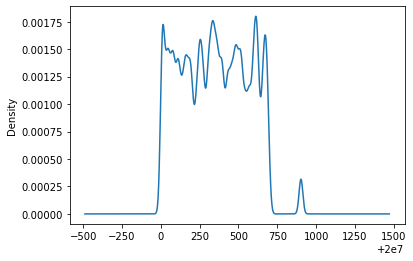

In [21]:
df_tr['TAXI_ID'].plot(kind='kde')
#Not much difference in samples between different drivers, consider dropping the column

<AxesSubplot:ylabel='Density'>

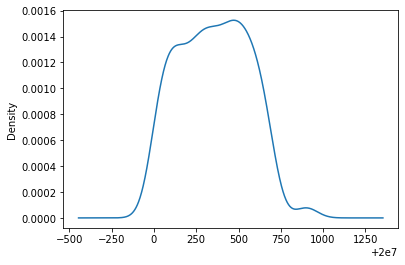

In [22]:
predict_set['TAXI_ID'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

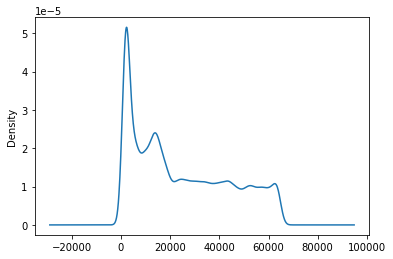

In [23]:
df_tr['ORIGIN_CALL'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

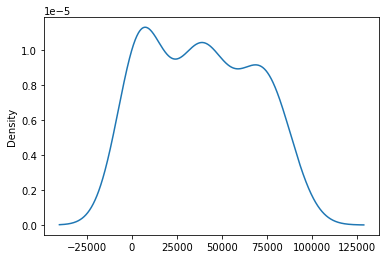

In [24]:
predict_set['ORIGIN_CALL'].plot(kind='kde')

/tmp/ipykernel_106/2946393032.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = X.corr()


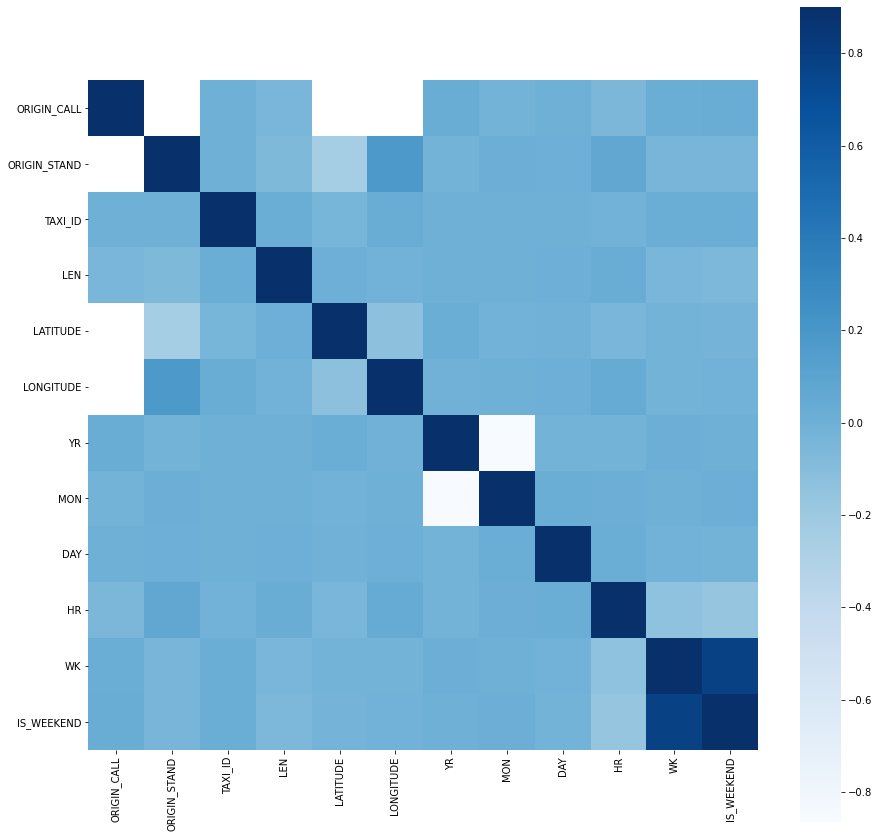

In [25]:
def draw_corr_picture(X):
    corrmat = X.corr()
    plt.subplots(figsize=(15,15))
    sns.heatmap(corrmat,vmax=0.9,square=True,cmap='Blues')
    plt.show()

draw_corr_picture(df_tr)

In [26]:
df_tr=df_tr.drop(['ORIGIN_CALL','TAXI_ID','ORIGIN_STAND'],axis=1)
predict_set=predict_set.drop(['ORIGIN_CALL','TAXI_ID','ORIGIN_STAND'],axis=1)

In [ ]:
"""all_features['ORIGIN_STAND'] = all_features['ORIGIN_STAND'].fillna(0)
latitude = []
longitude = []
for idx, row in all_features.iterrows():
    stand = all_features.loc[idx, 'ORIGIN_STAND']
    latitude.append(stand_location.loc[stand, 'Latitude'])
    longitude.append(stand_location.loc[stand, 'Longitude'])
all_features.head()
all_features['ORIGIN_LATITUDE'] = latitude
all_features['ORIGIN_LONGITUDE'] = longitude
all_features.head()"""

In [27]:
#standardize numeric entry values, parse taxi-id into strings
df_tr['YR'] = df_tr['YR'].astype(str)
predict_set['YR'] = predict_set['YR'].astype(str)
#There are overall 50000 different callers, so it's impossible to create one-hot for them

In [28]:
#create one-hot columns for discrete values
df_tr = pd.get_dummies(df_tr, dummy_na=False)
predict_set = pd.get_dummies(predict_set, dummy_na=False)
df_tr.head()

,LEN,LATITUDE,LONGITUDE,MON,DAY,HR,WK,IS_WEEKEND,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2013,YR_2014,HR_TYPE_day,HR_TYPE_night,HR_TYPE_rush
0,330,0.000000,0.00000,7,1,0,0,False,0,0,1,1,0,0,1,0
1,270,-0.034448,-0.74524,7,1,0,0,False,0,1,0,1,0,0,1,0
2,960,0.000000,0.00000,7,1,0,0,False,0,0,1,1,0,0,1,0
3,630,0.000000,0.00000,7,1,0,0,False,0,0,1,1,0,0,1,0
4,420,0.000000,0.00000,7,1,0,0,False,0,0,1,1,0,0,1,0


In [ ]:

df_tr.to_csv('df_tr.csv')
predict_set.to_csv('predict_set.csv')

In [29]:
predict_set.head()

,LATITUDE,LONGITUDE,MON,DAY,HR,WK,IS_WEEKEND,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,HR_TYPE_day,HR_TYPE_night,HR_TYPE_rush
0,-1.035266,1.384046,8,14,17,3,False,0,1,0,1,0,0,1
1,-1.291688,0.441726,8,14,17,3,False,0,1,0,1,0,0,1
2,-1.035266,1.384046,8,14,17,3,False,0,1,0,1,0,0,1
3,-1.689330,0.316292,8,14,17,3,False,0,1,0,1,0,0,1
4,-1.062295,0.104104,8,14,17,3,False,0,1,0,1,0,0,1


In [ ]:
df_tr = pd.read_csv('df_tr.csv')
predict_set=pd.read_csv('predict_set.csv')
df_tr.head()

In [36]:
df_tr=df_tr.astype('float32')
predict_set=predict_set.astype('float32')

In [ ]:
df_tr=df_tr.drop(['Unnamed: 0'],axis=1)
predict_set=predict_set.drop(['Unnamed: 0'],axis=1)

In [37]:
print(df_tr.dtypes)

LATITUDE         float32
LONGITUDE        float32
MON              float32
DAY              float32
HR               float32
WK               float32
IS_WEEKEND       float32
CALL_TYPE_A      float32
CALL_TYPE_B      float32
CALL_TYPE_C      float32
YR_2014          float32
HR_TYPE_day      float32
HR_TYPE_night    float32
HR_TYPE_rush     float32
dtype: object


In [38]:
df_tr.head()

,LATITUDE,LONGITUDE,MON,DAY,HR,WK,IS_WEEKEND,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,HR_TYPE_day,HR_TYPE_night,HR_TYPE_rush
0,0.000000,0.00000,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.034448,-0.74524,7.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.000000,0.00000,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.000000,0.00000,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.000000,0.00000,7.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [39]:
predict_set.head()

,LATITUDE,LONGITUDE,MON,DAY,HR,WK,IS_WEEKEND,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,YR_2014,HR_TYPE_day,HR_TYPE_night,HR_TYPE_rush
0,-1.035266,1.384046,8.0,14.0,17.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,-1.291688,0.441726,8.0,14.0,17.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,-1.035266,1.384046,8.0,14.0,17.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-1.689330,0.316292,8.0,14.0,17.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-1.062295,0.104104,8.0,14.0,17.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [30]:
df_tr=df_tr.drop(['YR_2013'],axis=1)

In [33]:
train_labels = torch.tensor(df_tr['LEN'].values)
df_tr=df_tr.drop(['LEN'],axis=1)

In [40]:
train_features = torch.tensor(df_tr.values)
predict_input = torch.tensor(predict_set.values)

In [41]:
print(train_labels.shape)
print(train_features.shape)
print(predict_input.shape)

torch.Size([1704759])
torch.Size([1704759, 14])
torch.Size([320, 14])


In [42]:
print(train_labels[0])
print(train_features[0])
print(predict_input[0])

tensor(330)
tensor([0., 0., 7., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.])
tensor([-1.0353,  1.3840,  8.0000, 14.0000, 17.0000,  3.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000])


In [44]:
del df_tr

In [ ]:
sns.histplot(data=train_labels)
plt.xlim(0,4000)
plt.show()

In [43]:
torch.save(train_features,'train_features.pt')
torch.save(train_labels,'train_labels.pt')
torch.save(predict_input,'predict_input.pt')

In [ ]:
#Tasks and something to think about

#I ignored callers' id and make taxi-id a categorical feature(which creates 400 columns and seems not efficient), there may be better ways to do that

#building model

#Use sklearn for something like gradient boosting or random forest, manually build a neural network

#Model Selection: Gradient Boosting,Random Forest,Extra Randomized Trees, SVM, Linear Regression, Logistic Regression, Neural Networks

#Try Ensemble Learning, maybe stacking different models